<b><font size="+3">Training a machine learning model to judge you and I shallowly based on looks</font></b>

This notebook will document the analysis and the training of a machine learning model on a human faces dataset that I meticulously crawled from Reddit.

The model will aim to decide, amongst other things, the attractiveness of the subject displayed in an image. /r/rateme has just the right data for this, with the subject's age, gender and most importantly their 'attractiveness', as judged by real people documented in each thread.

<b><font size="+2">Setting up</font></b>

In [1]:
# importing the relevant libraries
# visualisation
import matplotlib.pyplot as plt
%matplotlib inline

# models and data processing
import sklearn.linear_model as models
import sklearn.neural_network as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline

# reading CSV 
import numpy as np
from pandas import read_csv
from pandas import DataFrame
# we get some errors when plotting the graph, supressing these for now
_ = np.seterr(invalid='ignore')

At this point, we have already:
- gathered the data (rating, age + picture) from reddit, /r/rateme subreddit
    - the data is gathered using regular expressions on the comments section and the title.
    - for the rating, we simply took an average of all the ratings in the comments
    - the age of the subject is present for most posts in the post title
- encoded the faces using VGG-face to obtain a feature vector for each face
- formed .csv files, for male and female faces, where each row corresponds to a datapoint. 
    - The first 4096 entries are the features from VGG
    - the second to last column are the face's rating
    - the last column is the face's age

In [2]:
# location of data stored
data_root = './data/vgg_encoded/'
male_csv = data_root + 'male.csv'
female_csv = data_root + 'female.csv'

Interestingly, there are much more males than females who wanted to get their faces rated on /r/rateme! For this reason, we will first try out the female part of our dataset (we have ~12,500 female entries, and ~37,500 male entries)

This could potentially be due to a combination of:
- males not receiving as much feedback on their appearance during their day-to-day life compared to females
- there simply being more males than females on reddit, or on /r/rateme

So now all that's left is to train the regressor on the face's ratings!

In [3]:
# reading in the CSV file as an numpy array
# the 1: is due to my stupidity - I've accidentally also saved the index into the first column of the .csv
# and finally dropna() is to deal with the NaN's we have in the dataset
female_data = read_csv(female_csv).dropna().values[:, 1:]

X_female, targets_female = female_data[:, :-2], female_data[:, -2:]
rating_female, age_female = targets_female[:, 0], targets_female[:, 1]

# perform a train/test/validation split. 80% used for training, 10% for testing and 10% for validating
X_female_train, X_female_val, targets_female_train, targets_female_val = train_test_split(
    X_female, targets_female, test_size=0.2)
#X_female_val, X_female_test, targets_female_val, targets_female_test = train_test_split(
#    X_female_other, targets_female_other, test_size=0.5, shuffle=False)

# first column is rating, second column is age
rating_female_train, age_female_train = targets_female_train.T
rating_female_val, age_female_val = targets_female_val.T
#rating_female_test, age_female_test = targets_female_other.T

<b><font size="+2">Visualisation</font></b>

Before we start, let's take a look at what our data looks like.

Let's first note down some summary statistics:

In [4]:
# summary statistics
rating_age_female_data = {'rating': rating_female, 'age': age_female}
rating_age_female_df = DataFrame(data=rating_age_female_data)
rating_age_female_df.describe()

,age,rating
count,13535.000000,13535.000000
mean,21.308607,6.833825
std,17.574305,1.047918
min,1.000000,1.500000
25%,19.000000,6.308000
50%,20.000000,6.990625
75%,23.000000,7.533712
max,2017.000000,10.000000


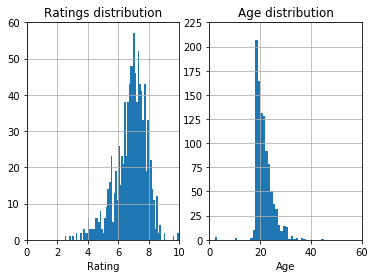

In [5]:
# histogram for ratings
plt.subplot(121)
plt.hist(rating_female[:1000], bins=100, range=(0,10))
plt.title('Ratings distribution'); plt.xlabel('Rating'); plt.axis([0,10,0,60])
plt.grid(True)

# histogram for age
plt.subplot(122)
plt.hist(age_female[:1000], bins=60, range=(0,60))
plt.title('Age distribution'); plt.xlabel('Age'); plt.axis([0,60,0,225])
plt.grid(True)

plt.show(); plt.clf()

From these plots we can see that ratings distributions follows a normal / log normal distribution with a mean of around 7 (!), whilst the age distribution resembles quite closely a gamma distrubtion. 

(!): Perhaps guys just find all girls beautiful after all, or perhaps people are a little too kind on /r/rateme! As a result, should we normalise our output to a mean of 5, so that it resembles more closely the 'ideal' attractiveness scale? <font size="-2">I think there is no need. As a man I fall in love with every other women I see on the streets, so an average of 7 is not surprising at all. ;)</font>

Let's also take a look at the features:

In [6]:
# pick 10 sample features randomly, from the interval [0, 4095]
sample_points = np.trunc(np.random.random_sample(10) * 4096).astype(int)
feature_sample = X_female[:, sample_points]

# and print out the statistics of the sampled features.
print(DataFrame(data=feature_sample, columns=sample_points).describe())

               221           2901          415           224           2702  \
count  13535.000000  13535.000000  13535.000000  13535.000000  13535.000000   
mean     502.136368    241.022659    239.529857     42.957660    313.193011   
std     1161.070354    811.535517    728.811630    313.491259    878.168713   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%      196.102325      0.000000      0.000000      0.000000      0.000000   
max     9495.917969   9578.944336   8616.874023   5178.677734  11952.262695   

               3065          1327          506           2999          198   
count  13535.000000  13535.000000  13535.000000  13535.000000  13535.000000  
mean    1729.796005     18.272629    112.829844    194.715889     45.876291  
std     2022.524311    166.975604    477.800345    717

Looks like the features are quite sparse. In order to take a closer look we need to filter out the places where the feature is non-present. 

In [7]:
# taking a closer look at the first of the sampled features
feature_0 = feature_sample[:, 0]
feature_0_nonzero = feature_0[feature_0 > 1e-2]

# and print out its descriptive statistics
print(DataFrame(feature_0_nonzero).describe())

                 0
count  3700.000000
mean   1836.869120
std    1574.806307
min       0.287262
25%     632.830185
50%    1399.818604
75%    2651.921875
max    9495.917969


It can be seen that the features are quite large in magnitude - thus some standardization is definitely needed. What this does also show is that the data seems usable, from as far as I can see, in that there are not obvious faults that can be picked up immediately.

Anyways, with all that being said, let's train our regressors for now and see what kind of results we get.

<b><font size="+2">Preprocessing</font></b>

Before we fit our model, we first standardise our features to help our model converge. To do this, we will make use of scikit learn's tools, which will standardise our features for us. We will also make use a pipeline so to streamline the work that goes on before our data goes through our model in the future (i.e. testing phase and beyond)

Standardisation in fact becomes not-even-a-one-liner with sklearn, (thanks to the StandardScaler class). So let's move onto the next step, which is choosing a regression model.

<b><font size="+2">Regression</font></b>

There are a few models which will potentially do the job. Models such as Linear Regression (we will use a variant such as Lasso), Bayesian Regression or a neural network could all potentially work. We will try to evaluate a few of these on our data.

First up is Lasso regression. Scikit learn surprised me once again with automatic cross-validation. And luckily enough, Lasso has a corresponding CV class, LassoCV which will automatically do cross-validation for us.

In [8]:
# Lasso model with standardisation.
# ``alphas`` is for cross-validation: the range of regularization penalty we want to try
alphas = np.linspace(0, 1e-1, num=100)
lasso = make_pipeline(StandardScaler(), models.LassoCV(alphas=alphas, n_jobs=-1))
# fit lasso regression
lasso.fit(X_female_train, rating_female_train)
print('alpha chosen:', lasso.steps[1][1].alpha_)

/home/pingshiyu/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pingshiyu/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)


alpha chosen: 0.0313131313131


This resulted in choosing alpha=0.05 as our penalty. Let's take a look at the results given by this value. We define an evaluation function whilst we're at it so that we can evaluate other models quickly also.

In [9]:
def mse(y, y_):
    '''
    Returns the mean squared error between ``y`` and ``y_``
    y, y_: numpy arrays of the same dimension
    '''
    return np.mean((y - y_)**2)

def evaluate_model(model, Xval=X_female_val, yval=rating_female_val):
    '''
    Given a model, output evaluation information about the model's performance on the validation set.
    '''
    # evaluate the model
    val_prediction = model.predict(Xval)
    print('MSE on test set:', mse(val_prediction, yval))
    print('R^2 score:', model.score(Xval, yval))
    print('predictions statistics:')
    print(DataFrame({'prediction': model.predict(Xval), 'actual': yval}).describe())

We also visualise with a scatterplot, where we can see how the prediction relates to the actual values. If the model were perfect, then that means all of the predictions and the actual values are equal - thus all of the points of the plot will be along the line $y = x$. The further the plot deviates from that line, the less 'similar' our predictor is to the correct values.

In [10]:
def model_scatterplot(model, Xval=X_female_val, yval=rating_female_val):
    '''
    Visualize the model with a scatter-plot. This will show us how 'correlated' the model predictions and the actual 
    test set are. 
    
    A perfectly correlated dataset should look like the graph y = x, where it is just a straight diagonal line.
    '''
    # plotting the graph of the predictions
    pred = model.predict(Xval)
    plt.plot(yval, model.predict(Xval), 'ro', markersize=0.5, label='model output')
    plt.plot(np.arange(max(yval)), np.arange(max(yval)), 'b--', linewidth=0.5, label='ideal')
    plt.xlabel('actual'); plt.ylabel('predicted'); plt.legend()
    plt.show(); plt.clf()

MSE on test set: 1.07954583694
R^2 score: 0.00649863261172
predictions statistics:
            actual   prediction
count  2707.000000  2707.000000
mean      6.834123     6.835813
std       1.042597     0.057494
min       2.000000     6.491435
25%       6.319123     6.810055
50%       6.994872     6.841292
75%       7.536595     6.866237
max      10.000000     7.078593


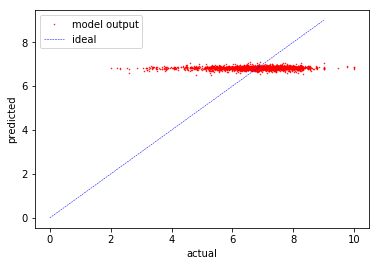

In [11]:
# print the results
evaluate_model(lasso)
model_scatterplot(lasso)

Unfortunately, this value of alpha resulted in an R^2 score very close to zero. Implying the model is severely underfitting - in fact from the scatterplot, the model is just predicting the average of the dataset for all points!

The model is in very bad health, and some treatment is needed immediately. 

<font size="+1"><b>Diagnosing the illness of linear regression</b></font>

<font size="+1">Plotting the MSE against model complexity</font>

First thing we need to find out is how the model varies according to `alpha`, our regularization parameter. The value of `alpha` corresponds to the 'complexity' of the model, the lower the value of `alpha`, the more 'complex' it is. A more complex model is more likely to overfit, and a less complex model is more likely to underfit. 

Thus, when
- `alpha` is small: $\implies$ the model is more complex $\implies$ the model may overfit $\implies$ lower training error; higher testing error
- `alpha` is big: $\implies$ the model is less complex $\implies$ the model may underfit $\implies$ higher training error; similarly high validation error

So, if we plot the training and testing errors on a graph, against the value of `alpha` we choose for our model, we may expect for the training error curve to:
- be high for small `alpha`, and dropping as `alpha` gets larger

in the meanwhile, the validation error curve may:
- be high for small `alpha`, and also high for large `alpha`. 

So between those two curves, there should exist a sweet spot for a choice of `alpha` where the MSE for the validation set is not too high, and for the training set not too close to zero. This `alpha` should be close to where the model is neither overfitting nor underfitting.

Let's plot the graph and see what it looks like in theory.

In [12]:
def plot_mse_graph(Model, X, y, Xval, yval, alpha_range=(0,0.1), points=100):
    '''
    Plots the graph of alpha against the MSE of the ``Model`` on the training and validation sets.
    '''
    training_MSE, validation_MSE = [], []
    # loop over the range of alphas
    alphas = np.linspace(*alpha_range, num=points)
    for alpha in alphas:
        # create and fit the model on training set
        model = make_pipeline(StandardScaler(), Model(alpha))
        model.fit(X, y)
        
        # evaluate the MSE on training and validation set
        training_MSE.append(mse(y, model.predict(X)))
        validation_MSE.append(mse(yval, model.predict(Xval)))
        
    # plot the data
    training_line = plt.plot(alphas, training_MSE, label='training')
    validation_line = plt.plot(alphas, validation_MSE, label='validation')
    plt.xlabel('alpha'); plt.ylabel('MSE'); plt.legend()
    plt.grid(True)
    plt.show(); plt.clf()

/home/pingshiyu/.local/lib/python3.6/site-packages/sklearn/pipeline.py:250: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/home/pingshiyu/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/pingshiyu/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


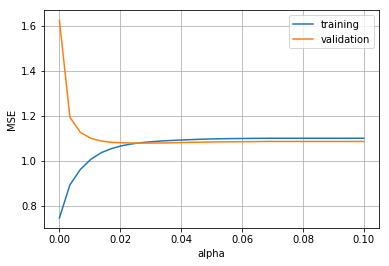

In [13]:
# plotting the complexity vs. MSE graph
plot_mse_graph(models.Lasso, 
               X_female_train, rating_female_train, 
               X_female_val, rating_female_val,
               points=30)

Unfortunately, from this graph, it can be seen that there is not really a 'sweet spot' where the model is neither underfitting nor overfitting. In fact, the validation error never dips below ~1.1, meaning that the model might as well be guessing the mean for everything at that point, seeing as the standard deviation is only ~1.04.

<font size="+1">Residual graph</font>

Another way to have more insight into why our model isn't behaving as it should is to plot the residual graph - where we plot a feature against the residual (defined as $\mathbf{e} = \mathbf{y}_{actual} - \mathbf{y}_{pred}$). This can tell us if the model would indeed fit better on a nonlinear model, i.e. when we see a nonlinear pattern emerging on the graph, then we know that a linear model may not suffice.

In [14]:
def residual_graph(features, pred, target, relevant_points=True):
    '''
    Given a model's predictions, the model's target as well as the features, we plot the residual graph for each of
    the features. ``relevant_points`` is an option to only plot points where that feature is non-zero (greater than 
    some small ``epsilon``). 
    pred, target: 1-d np arrays of the same size
    features: 2-d np array, with number of rows equalling the length of pred and target. Each row is a datapoint.
    relevant_points: boolean
    '''
    # calculate the scaled feature and the residual
    residual = target - pred
    feature_scaled = preprocessing.scale(features)
    
    # loop over each feature and plot the graph
    for i, feature in enumerate(feature_scaled.T):
        feature_plot, residual_plot = feature, residual
        # only samples where the feature is nonzero
        if relevant_points:
            relevant_index = feature_plot > 1e-2
            feature_plot, residual_plot = feature[relevant_index], residual[relevant_index]
        
        plt.plot(feature_plot, residual_plot, 'ro', markersize=1)
        plt.xlabel('feature {}'.format(i)); plt.ylabel('residual')
        plt.show(); plt.clf();

As the current linear regression model only fits a straight line, we train another model that overfits on purpose so that we can see its issues.

In [15]:
# train a new lasso model
from sklearn.preprocessing import FunctionTransformer
lasso_overfit = make_pipeline(StandardScaler(), models.Lasso(alpha=0.01))
lasso_overfit.fit(X_female_train, rating_female_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

MSE on test set: 1.10195241454
R^2 score: -0.0141220438973
predictions statistics:
            actual   prediction
count  2707.000000  2707.000000
mean      6.834123     6.840088
std       1.042597     0.198059
min       2.000000     5.613513
25%       6.319123     6.730424
50%       6.994872     6.847514
75%       7.536595     6.954861
max      10.000000     7.675564


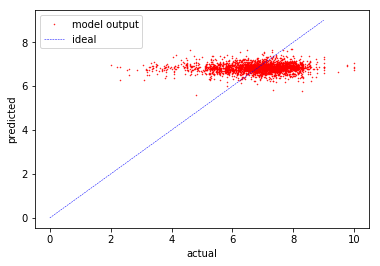

In [16]:
# evaluate the overfitting model
evaluate_model(lasso_overfit)
model_scatterplot(lasso_overfit)

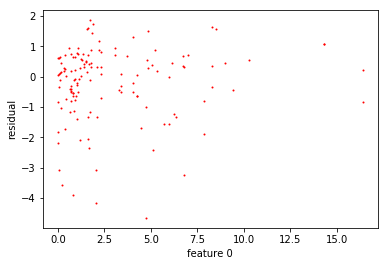

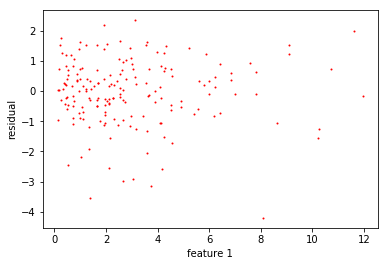

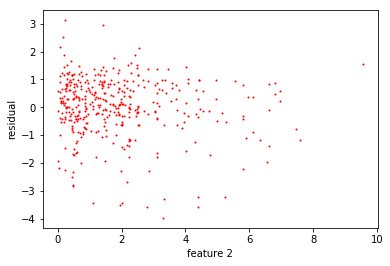

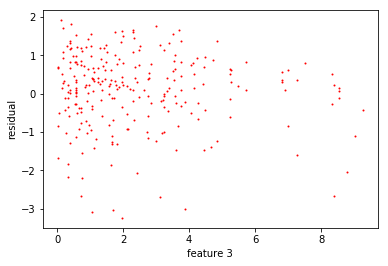

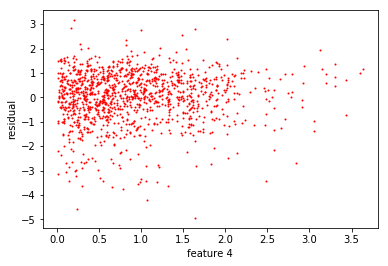

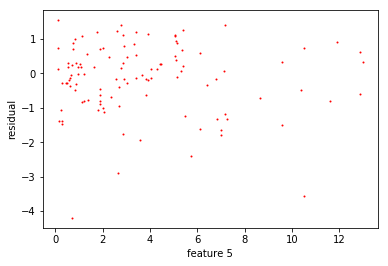

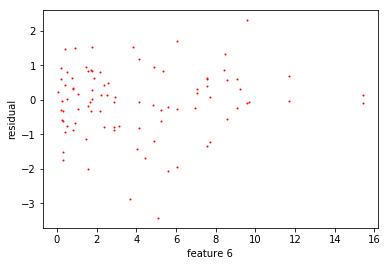

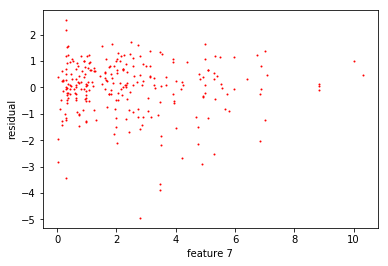

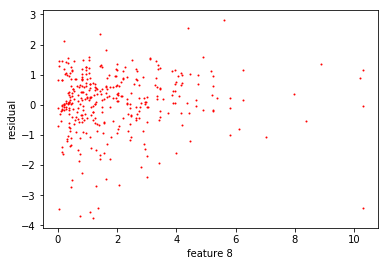

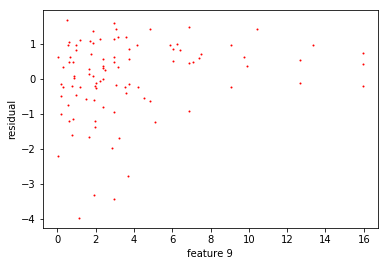

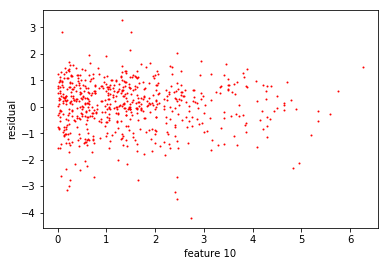

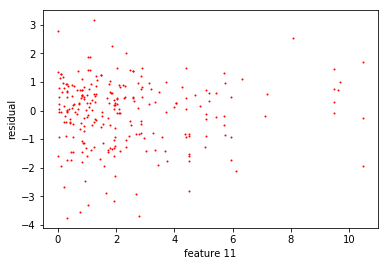

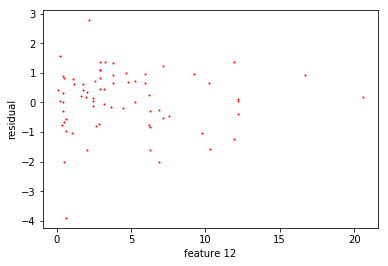

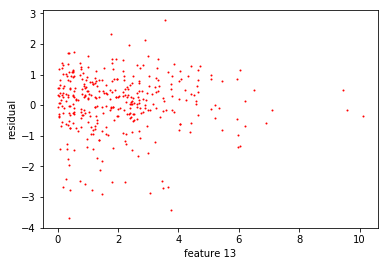

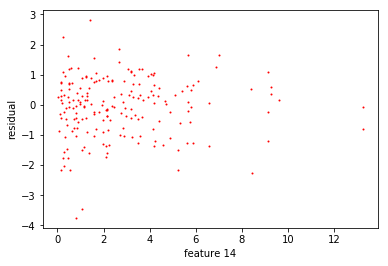

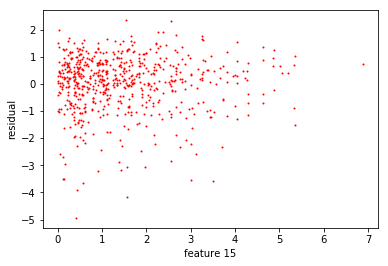

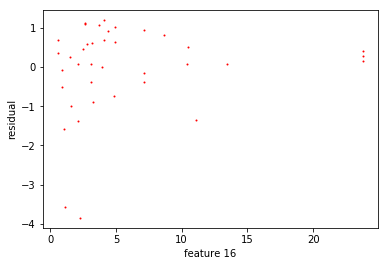

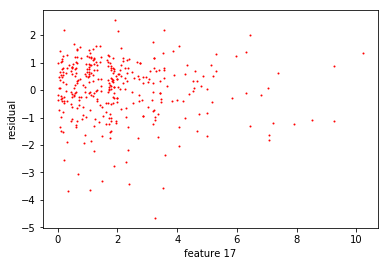

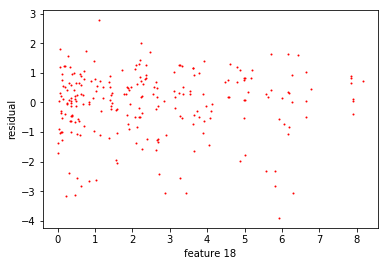

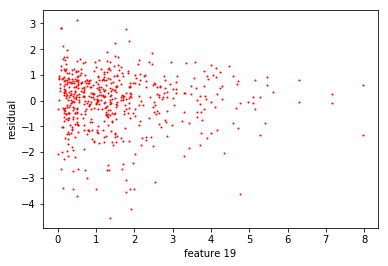

In [17]:
# first pick a random sample of the 4096 features
sample_points = np.trunc(np.random.random_sample(20) * 4096).astype(int)
feature_sample = X_female_val[:, sample_points]

# obtain the prediction for ``lasso_overfit``:
predictions = lasso_overfit.predict(X_female_val)

# now we plot the residual graph for each of the samples
residual_graph(feature_sample, predictions, rating_female_val)

Some patterns can be observed on the residual graph. For example

<b> Diagnosis: A linear model is not complex enough to model our attractiveness function. </b>

<b><font size="+2">Bayesian Regression</font></b>

Next we will give Bayesian Regression a shot. This model is preset in the `sklearn` library. We will quickly give it a run to see if the results are promising.

In [18]:
# initialize and fit the bayesian (ridge) regression model
bayes = make_pipeline(StandardScaler(), models.BayesianRidge())
bayes.fit(X_female_train, rating_female_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('bayesianridge', BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False))])

MSE on test set: 1.08143117574
R^2 score: 0.0047635634662
predictions statistics:
            actual   prediction
count  2707.000000  2707.000000
mean      6.834123     6.837664
std       1.042597     0.106546
min       2.000000     6.394778
25%       6.319123     6.772607
50%       6.994872     6.837594
75%       7.536595     6.901577
max      10.000000     7.294379


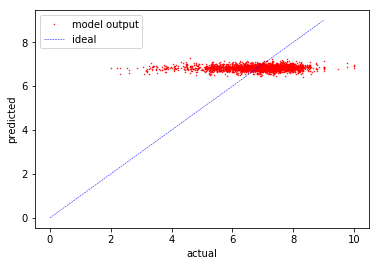

In [19]:
# evaluate the model
evaluate_model(bayes)
model_scatterplot(bayes)

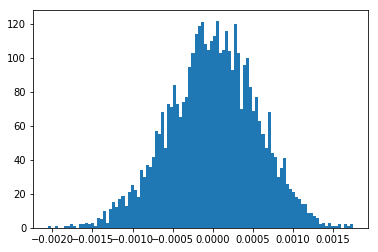

In [20]:
# seeing the distribution of the weights
bayes_model = bayes.steps[1][1]
plt.hist(bayes_model.coef_, bins=100)
plt.show(); plt.clf()

Unfortunately, Bayesian Ridge Regression, still being a linear model, does not fare much better than other forms of linear regression. We therefore now move on to some non-linear models in search for a slither of hope.

<b><font size="+2">Neural Network Model</font></b>

As the model seemed a little too complicated for a linear model, it would seem natural to try something more complicated, for example a neural network. Scikit-learn once again has a preset neural network model in their library, and we will be using that interface here also.

We will be using an adaptive learning rate, where it begins at a certain value, i.e. $10^{-2}$ and is decreased if the loss is not improved for two consecutive epochs.

In [21]:
# defining and fitting the network
network = make_pipeline(StandardScaler(), 
                        nn.MLPRegressor(hidden_layer_sizes=(300,), solver='adam',
                                        learning_rate='adaptive', learning_rate_init=1e-4,
                                        verbose=True))
network.fit(X_female_train, rating_female_train)

Iteration 1, loss = 15.42918745
Iteration 2, loss = 1.99495412
Iteration 3, loss = 0.72453709
Iteration 4, loss = 0.59887629
Iteration 5, loss = 0.53345121
Iteration 6, loss = 0.50114120
Iteration 7, loss = 0.48487842
Iteration 8, loss = 0.47176559
Iteration 9, loss = 0.46568776
Iteration 10, loss = 0.46020705
Iteration 11, loss = 0.46016964
Iteration 12, loss = 0.45599471
Iteration 13, loss = 0.45591175
Iteration 14, loss = 0.46489490
Iteration 15, loss = 0.46654358
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlpregressor', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='adaptive',
   ...e=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False))])

MSE on test set: 1.53828389271
R^2 score: -0.415676017215
predictions statistics:
            actual   prediction
count  2707.000000  2707.000000
mean      6.834123     6.846839
std       1.042597     0.684513
min       2.000000     3.943186
25%       6.319123     6.462810
50%       6.994872     6.921145
75%       7.536595     7.296159
max      10.000000     8.994077


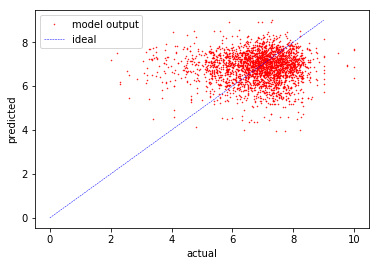

In [22]:
# evaluate the model
evaluate_model(network)
model_scatterplot(network)

<b><font size="+2">Boosting Models</font></b>

We will also try a range of boosting models to see how it performs.

<font size="+1">Gradient Boosting</font>

In [23]:
import sklearn.ensemble as ensemble

# use the gradient-boosting model
gradient_boost = make_pipeline(StandardScaler(), ensemble.GradientBoostingRegressor())
gradient_boost.fit(X_female_train, rating_female_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, mi...s=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

MSE on test set: 1.10435361344
R^2 score: -0.0163318568712
predictions statistics:
            actual   prediction
count  2707.000000  2707.000000
mean      6.834123     6.835507
std       1.042597     0.189687
min       2.000000     5.428806
25%       6.319123     6.764579
50%       6.994872     6.853757
75%       7.536595     6.937818
max      10.000000     7.518943


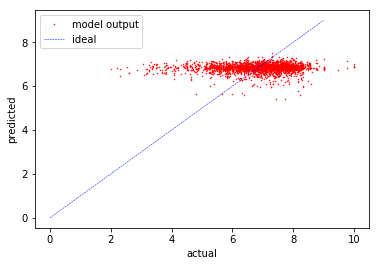

In [24]:
# evaluate the model
evaluate_model(gradient_boost)
model_scatterplot(gradient_boost)

<font size="+1">AdaBoost</font>

In [25]:
# use the model
adaboost = ensemble.AdaBoostRegressor(loss='exponential')
adaboost.fit(X_female_train, rating_female_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='exponential',
         n_estimators=50, random_state=None)

MSE on test set: 1.34328867828
R^2 score: -0.236222764246
predictions statistics:
            actual   prediction
count  2707.000000  2707.000000
mean      6.834123     6.347417
std       1.042597     0.152201
min       2.000000     4.997041
25%       6.319123     6.273825
50%       6.994872     6.357359
75%       7.536595     6.453037
max      10.000000     6.849445


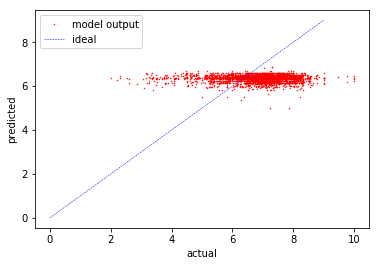

In [26]:
# evaluate the model
evaluate_model(adaboost)
model_scatterplot(adaboost)

<b><font size="+2">Bagging Regressor</font></b>

In [27]:
# use the bagging model
bagging = ensemble.BaggingRegressor()
bagging.fit(X_female_train, rating_female_train)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

MSE on test set: 1.52429871342
R^2 score: -0.402805517169
predictions statistics:
            actual   prediction
count  2707.000000  2707.000000
mean      6.834123     6.836733
std       1.042597     0.668955
min       2.000000     3.729185
25%       6.319123     6.463249
50%       6.994872     6.921237
75%       7.536595     7.297641
max      10.000000     9.152884


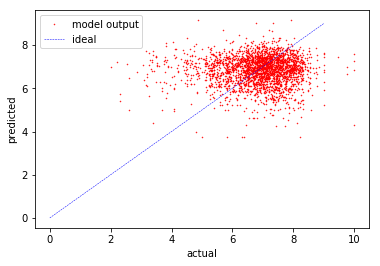

In [28]:
# evaluate the model
evaluate_model(bagging)
model_scatterplot(bagging)

<b><font size="+2">Random Forest Regressor</font></b>

In [29]:
# use the RF model
random_forest = ensemble.RandomForestRegressor()
random_forest.fit(X_female_train, rating_female_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

MSE on test set: 1.55604759325
R^2 score: -0.432023874041
predictions statistics:
            actual   prediction
count  2707.000000  2707.000000
mean      6.834123     6.820936
std       1.042597     0.680178
min       2.000000     3.723264
25%       6.319123     6.445574
50%       6.994872     6.900220
75%       7.536595     7.282593
max      10.000000     8.807843


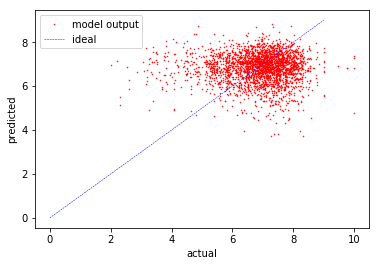

In [30]:
# evaluate the model
evaluate_model(random_forest)
model_scatterplot(random_forest)

<b><font size="+2">Support Vector Machine</font></b>

<font size="+1">NuSVR</font>

In [31]:
import sklearn.svm as svm

# use the NuSVR model
nusvm = svm.NuSVR()
nusvm.fit(X_female_train, rating_female_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

MSE on test set: 1.28006167817
R^2 score: -0.178035229343
predictions statistics:
            actual   prediction
count  2707.000000  2707.000000
mean      6.834123     6.893411
std       1.042597     0.445649
min       2.000000     4.894796
25%       6.319123     6.756283
50%       6.994872     6.894796
75%       7.536595     7.138198
max      10.000000     7.894796


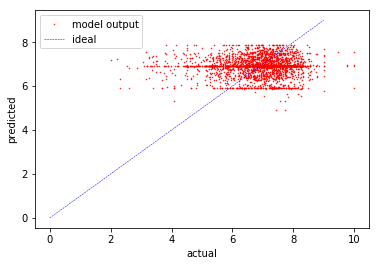

In [32]:
# evaluate the model
evaluate_model(nusvm)
model_scatterplot(nusvm)

<font size="+1">SVR</font>

In [33]:
# use the SVR model
svm = svm.SVR()
svm.fit(X_female_train, rating_female_train)

KeyboardInterrupt: 

In [ ]:
# evaluate the model
evaluate_model(svm)
model_scatterplot(svm)

<font size="+2"> <b> Testing section </b> </font>

In [ ]:
# import new data
from sklearn import datasets

diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [ ]:
lasso = models.Lasso()
lasso.fit(X_female_train, age_female_train)

In [ ]:
# evaluate
evaluate_model(lasso)
print(mse(lasso.predict(X_female_train), age_female_train))

In [ ]:
pred = lasso.predict(X_female_test)
np.set_printoptions(suppress=True)

DataFrame({'pred': pred}).describe()

In [ ]:
# pick some sample features randomly, from the interval [0, 4095]
sample_points = np.trunc(np.random.random_sample(4000) * 4096).astype(int)
feature_sample = X_female[:, sample_points]

In [ ]:
# train classifier on a sample of features, see how that performs
feature_sample_train, feature_sample_test, rating_sample_train, rating_sample_test = train_test_split(
    feature_sample, rating_female, test_size=0.2)

lr = models.LinearRegression()
lr.fit(feature_sample_train, rating_sample_train)

lr.score(feature_sample_test, rating_sample_test)

In [78]:
# Training a classifier on to classify male/female, ensuring the data can be used for inferrence
female_data = read_csv(female_csv, nrows=3000).dropna().values[:, 1:]
male_data = read_csv(male_csv, nrows=3000).dropna().values[:, 1:]
female_features = female_data[:, :-2]
male_features = male_data[:, :-2]

# 0 is for males, 1 is for females. We assign labels to our dataset
female_class = np.ones(female_features.shape[0])
male_class = np.zeros(male_features.shape[0])
all_features = np.vstack([female_features, male_features])
all_classes = np.concatenate([female_class, male_class])

# make the train/test split
Xtrain, Xtest, ytrain, ytest = train_test_split(all_features, all_classes, test_size=0.1)

In [79]:
# train a logistic regression classifier
logistic_regression = make_pipeline(StandardScaler(), models.LogisticRegression(C=0.04))
logistic_regression.fit(Xtrain, ytrain)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [80]:
# evaluate the model
print('accuracy:', logistic_regression.score(Xtest, ytest))

accuracy: 1.0


           weights
count  4096.000000
mean     -0.002590
std       0.037784
min      -0.197703
25%      -0.026181
50%      -0.002165
75%       0.022097
max       0.139101


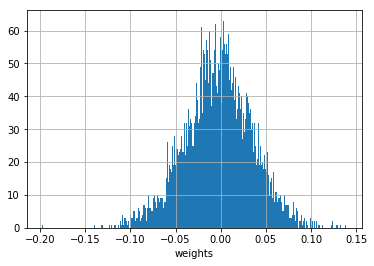

In [81]:
# summary of weights
classifier = logistic_regression.steps[1][1]
weights = classifier.coef_.flatten()
print(DataFrame(weights, columns=['weights']).describe())
plt.hist(weights, bins=300); plt.xlabel('weights'); plt.grid()
plt.show(); plt.clf()

In [84]:
# CV to find ideal C
lr_cv = make_pipeline(StandardScaler(), models.LogisticRegressionCV())
lr_cv.fit(Xtrain, ytrain)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregressioncv', LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

best c found: [ 0.04641589]
        weights_cv
count  4096.000000
mean     -0.001684
std       0.032821
min      -0.170914
25%      -0.022113
50%      -0.001295
75%       0.020155
max       0.117744


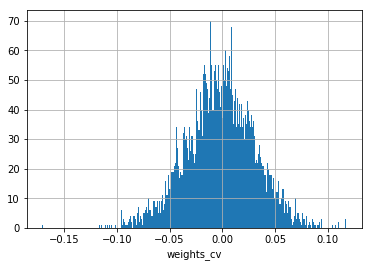

In [86]:
# extract alpha and evaluate model
lr_cv_classifier = lr_cv.steps[1][1]
c_best = lr_cv_classifier.C_
print('best c found:', c_best)

# print out statistics for weights
weights_cv = lr_cv_classifier.coef_.flatten()
print(DataFrame(weights_cv, columns=['weights_cv']).describe())
plt.hist(weights_cv, bins=300); plt.xlabel('weights_cv'); plt.grid()
plt.show(); plt.clf()